#### IMPORT

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import random

#### Preprocess Data

instantiate transforms class

In [2]:
# torchvision.transforms
# image transformations

# torchvision.transforms.Compose
# composes(chains) multiple Transform objects together
  # transform objects
    # z.B. transforms.CenterCrop(size), transforms.ColorJitter(brightness, contrast, saturation, hue), transforms.FiveCrop(size), transforms.Grayscale(num_output_channels), transforms.Pad(padding, fill, padding_mode)
  # can also chain with torch.nn.Sequential

# transforms = nn.Sequential(
#     transforms.CenterCrop(10),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# )

# script_transforms = torch.jit.script(transforms)



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # noramlize a tensor image with mean and std
])

set settings

In [3]:
batch_size = 32
epochs = 20
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

read data and instantiate dataloader

In [4]:
# read data from MNISt dataset
train_dataset = datasets.MNIST(root = './data', train = True, transform = transform, download = True)
test_dataset = datasets.MNIST(root = './data', train = False, transform = transform, download = True)

# load data with DataLoader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.04MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.07MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.49MB/s]


In [5]:
# check the dimensions of input image data
dimensions = [x.size() for x, _ in train_loader]
print(f'Image Data Shape:\t{set(dimensions)}')

# batch size: 32(of course)
# the number of channels: 1
# height: 28 pixels
# width: 28 pixels

Image Data Shape:	{torch.Size([32, 1, 28, 28])}


In [6]:
# assign feature and labels to X_train, y_train, X_test, y_Test variable
X_train, y_train = train_dataset.data, train_dataset.targets
X_test, y_test = test_dataset.data, test_dataset.targets

# check dimensions of each feature / label data
print(f'Training images:\t{str(X_train.shape):>}')
print(f'Test images:\t\t{str(X_test.shape):>}')
print(f'Training Labels:\t{str(y_train.shape):>}')
print(f'Test Labels:\t\t{str(y_test.shape):>}')

Training images:	torch.Size([60000, 28, 28])
Test images:		torch.Size([10000, 28, 28])
Training Labels:	torch.Size([60000])
Test Labels:		torch.Size([10000])


look up all unique labels

In [ ]:
labels = set([int(label) for label in y_train] + [int(label) for label in y_test])
print(*sorted(labels))

## 0 to 9 digits, 10 classes in total

0 1 2 3 4 5 6 7 8 9


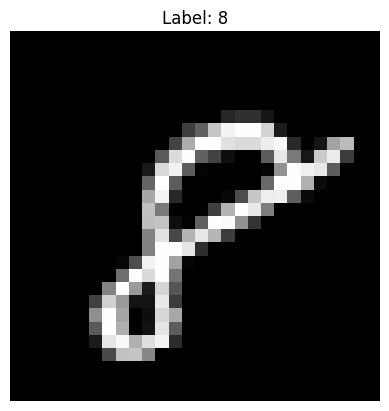

In [ ]:
# visuzlie one of the sample
plt.imshow(X_train[-1], cmap = 'gray')
plt.title(f'Label: {y_train[-1].item()}')
plt.axis('off')
plt.show()

#### Define Convolutional Neural Network
define CNN architecture

In [ ]:
print("short introduction to nn.Conv2d")
# import torch.nn as nn

# nn.Conv2d(in_channels, out_channels, kernel_size, stride, ):
print('''
    kargs:
      in_channels: the number of channels in the input image
      out_channels: the number of channels produced by the convolution
      kernel_size: the size of the convolving kernel
''')
  # nn.Conv2d(16, 33, 3, stride = 2) with square kernels and equal stride
  # nn.Conv2d(16, 33, (3, 5), stride = (2, 1), padding = (4, 2)) non-square kernels and unequal stride and with padding
  # nn.Conv2d(16, 33, (3, 5), stride = (2, 1), padding = (4, 2), dilation = (3, 1)) non-square kernels and unequal stride and with padding and dilation


short introduction to nn.Conv2d

    kargs:
      in_channels: the number of channels in the input image
      out_channels: the number of channels produced by the convolution
      kernel_size: the size of the convolving kernel



In [ ]:
print("short introduction to nn.linear")
# import torch.nn as nn

# nn.Linear(in_features, out_features):
print('''
  applies an affine linear transformation to the incoming data

    kargs:
      in_features: the size of each input sample
      out_features: the size of each output sample
  ''')
  # nn.Linear(in_features = (16 * 5 * 5), out_features = 120) # 16: final number of channels, (5, 5): kernel_size
  # nn.Linear(in_features = 120, out_features = 84) # just decreasing the number of features
  # nn.Linear(in_features = 84, out_features = 10) # again, just decreasing the number of features

short introduction to nn.linear

  applies an affine linear transformation to the incoming data

    kargs:
      in_features: the size of each input sample
      out_features: the size of each output sample
  


In [ ]:
class SimpleCNN1(nn.Module):
  def __init__(self):
    super(SimpleCNN1, self).__init__()

    # define convolutional layers
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 3, kernel_size = 3)
    self.conv2 = nn.Conv2d(3, 5, 3)

    # define activation function
    self.relu = nn.ReLU()

    # define pooling layer
    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)


    # define projection (dense) layers
    self.fc1 = nn.Linear(in_features = 5 * 5 * 5, out_features = 24)
    self.fc2 = nn.Linear(in_features = 24, out_features = 10)


  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.maxpool(x)
    x = self.relu(self.conv2(x))
    x = self.maxpool(x)
    x = x.view(x.size(0), -1) # Flatten the tensor
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# one without nn.Sequential

In [ ]:
class SImpleCNN2(nn.Module):
  def __init__(self):
    super(SImpleCNN2, self).__init__()

    self.embedding = nn.Embeddings()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 3, kernel_size = 3)
    self.conv2 = nn.Conv2d(3, 5, 3)
    self.relu = nn.ReLU()
    self.linear = nn.Linear(in_feaures, out_features)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

  def forwrad(self, inputs):
    output = self.relu(self.conv1(self.embedding(input)))
    output = self.pool(output)

    output = self.relu(self.conv2(output))
    output = self.pool(output)

    output = self.linear(output)

    return output

# one with nn.Sequential

execute and review

In [ ]:
# get model ready
model = SimpleCNN1().to(device)

#### Train

define criterion(loss function) and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

define train function

In [7]:
def train(model, loader):
  '''
  args:
    model: defined  model architecture
    loader: loaded data for training
  returns:
    avg_loss: average loss across samples of whole feeded batch
    accuracy: the ratio of correct predictions out of total number of predictions
  '''

  model.train()  # set model mode as train
  total_loss = 0
  correct = 0
  total = 0

  for x, y in loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad() # initialize weights as zero
    output = model(x) # forward step
    loss = criterion(output, y) # calculate loss
    loss.backward() # back propagation
    optimizer.step() # update parameters

    total_loss += loss.item() * y.size(0) ## 이거 좀 이해 안 되는데
    correct += (output.argmax(dim = 1) == y).sum().item() ## this too
    total += y.size(0)


  avg_loss = total_loss / total
  accuracy = correct / total
  return avg_loss, accuracy

define evaluation function

In [8]:
def evaluate(model, loader):
  model.eval() # set model mode as validation
  total_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = criterion(output, y)

      total_loss += loss.item() * y.size(0)
      correct += (output.argmax(dim = 1) == y).sum().item()
      total += y.size(0)

  avg_loss = total_loss / total
  accuracy = correct / total
  return avg_loss, accuracy

train for {epochs} times

In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
  train_loss, train_acc = train(model, train_loader)
  test_loss, test_acc = evaluate(model, test_loader)

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  test_losses.append(test_loss)
  test_accuracies.append(test_acc)

  print(f'[Epoch {epoch + 1}]'
        f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
        f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

[Epoch 1]Train Loss: 0.4429, Train Acc: 0.8633 | Test Loss: 0.1574, Test Acc: 0.9534
[Epoch 2]Train Loss: 0.1441, Train Acc: 0.9557 | Test Loss: 0.1148, Test Acc: 0.9664
[Epoch 3]Train Loss: 0.1134, Train Acc: 0.9647 | Test Loss: 0.0915, Test Acc: 0.9712
[Epoch 4]Train Loss: 0.0979, Train Acc: 0.9693 | Test Loss: 0.0875, Test Acc: 0.9725
[Epoch 5]Train Loss: 0.0887, Train Acc: 0.9725 | Test Loss: 0.0806, Test Acc: 0.9741
[Epoch 6]Train Loss: 0.0801, Train Acc: 0.9752 | Test Loss: 0.0805, Test Acc: 0.9715
[Epoch 7]Train Loss: 0.0751, Train Acc: 0.9759 | Test Loss: 0.0728, Test Acc: 0.9781
[Epoch 8]Train Loss: 0.0706, Train Acc: 0.9781 | Test Loss: 0.0723, Test Acc: 0.9764
[Epoch 9]Train Loss: 0.0663, Train Acc: 0.9789 | Test Loss: 0.0753, Test Acc: 0.9759
[Epoch 10]Train Loss: 0.0634, Train Acc: 0.9801 | Test Loss: 0.0680, Test Acc: 0.9779
[Epoch 11]Train Loss: 0.0612, Train Acc: 0.9806 | Test Loss: 0.0739, Test Acc: 0.9766
[Epoch 12]Train Loss: 0.0587, Train Acc: 0.9814 | Test Loss: 0.

#### Visualization
plot the learning curves

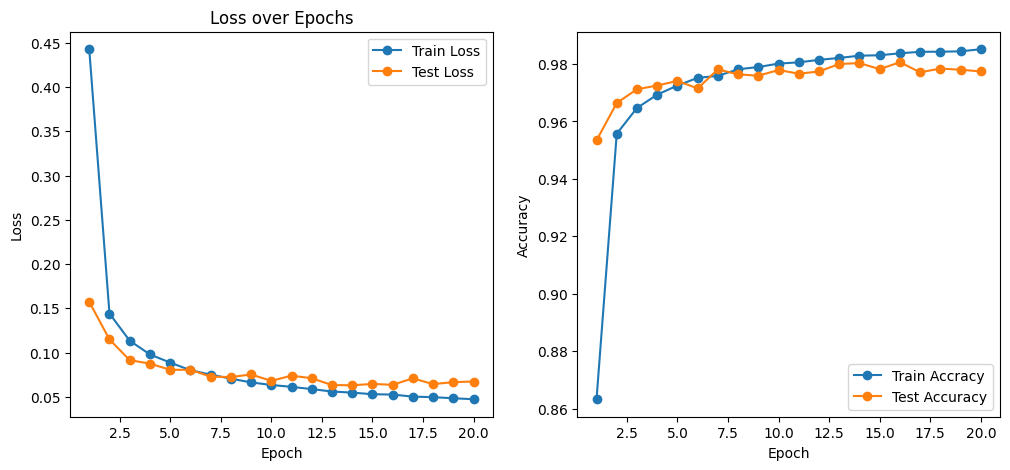

In [ ]:
x_epochs = range(1, epochs + 1)
plt.figure(figsize = (12, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, label = 'Train Loss', marker = 'o')
plt.plot(x_epochs, test_losses, label = 'Test Loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()


# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, label = 'Train Accracy', marker = 'o')
plt.plot(x_epochs, test_accuracies, label = 'Test Accuracy', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


#### Predict
define prediction function

In [ ]:
def show_random_predictions(model, dataset, num_images = 5):
  '''
  args:
    model:
    dataset:
    num_images:
  returns:
    No return, just float image and predictions
  '''

  idxs = random.sample(range(len(dataset)), num_images)
  images = torch.stack([dataset[i][0] for i in idxs])
  labels = torch.stack([dataset[i][1] for i in idxs])

  images = images.to(device)
  outputs = model(images)
  preds = outputs.argmax(dim = 1)

  plt.figure(figsize = (12, 3))
  for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap = 'gray')
    plt.title(f'GT: {labels[i].item()}\nPred:  {preds[i].item()}')
    plt.axis('off')
  plt.tight_layout()
  plt.show()


#### Define Residual Network

define residual block

In [71]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResidualBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)
    self.relu = nn.ReLU()
    self.norm = nn.BatchNorm2d(out_channels)


    if in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels,
                    kernel_size = 1, stride = 1, ),
          nn.BatchNorm2d(out_channels))
    else:
      self.shortcut = nn.Identity()

  def forward(self, x):
    identity = self.shortcut(x)
    out = self.relu(self.norm(self.conv1(x)))
    out = self.norm(self.conv2(out))
    out += identity

    return self.relu(out)

define residual network

In [77]:
class ResNetLike(nn.Module):
  def __init__(self):
    super(ResNetLike, self).__init__()
    self.stem = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3,
                  stride = 1, padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
    )

    self.layer1 = ResidualBlock(in_channels = 16, out_channels = 16) # freeze initial layers
    self.layer2 = ResidualBlock(in_channels = 16, out_channels = 16) # freeze initial layers
    self.layer3 = ResidualBlock(in_channels = 16, out_channels = 16) # freeze initial lzers
    self.layer4 = ResidualBlock(in_channels = 16, out_channels = 32)
    self.layer5 = ResidualBlock(in_channels = 32, out_channels = 64)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.dropout = nn.Dropout(p = 0.2) # prevent overfitting
    self.fc = nn.Linear(in_features = 64, out_features = 10) # dense layer

  def forward(self, x):
    out = self.stem(x)
    out = self.layer3(self.layer2(self.layer1(out)))
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.avgpool(out)
    out = self.dropout(torch.flatten(out, 1))
    return self.fc(out)

get model ready

In [78]:
model = ResNetLike().to(device)

define criterion(loss function) and optimizer

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

set settings

In [80]:
batch_size = 32
epochs = 10
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

execute and review

In [81]:
epochs = 10

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
  train_loss, train_acc = train(model, train_loader)
  test_loss, test_acc = evaluate(model, test_loader)

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  test_losses.append(test_loss)
  test_accuracies.append(test_acc)

  print(f'[Epoch {epoch + 1}]'
        f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}  | '
        f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

[Epoch 1]Train Loss: 0.2015, Train Acc: 0.9473  | Test Loss: 2.5527, Test Acc: 0.2468
[Epoch 2]Train Loss: 0.0696, Train Acc: 0.9788  | Test Loss: 1.6246, Test Acc: 0.5496
[Epoch 3]Train Loss: 0.0537, Train Acc: 0.9842  | Test Loss: 1.7862, Test Acc: 0.3901
[Epoch 4]Train Loss: 0.0458, Train Acc: 0.9862  | Test Loss: 2.0751, Test Acc: 0.4507
[Epoch 5]Train Loss: 0.0387, Train Acc: 0.9887  | Test Loss: 1.8559, Test Acc: 0.4108
[Epoch 6]Train Loss: 0.0363, Train Acc: 0.9890  | Test Loss: 0.9203, Test Acc: 0.6566
[Epoch 7]Train Loss: 0.0326, Train Acc: 0.9902  | Test Loss: 1.6184, Test Acc: 0.4980
[Epoch 8]Train Loss: 0.0279, Train Acc: 0.9914  | Test Loss: 1.3382, Test Acc: 0.5609
[Epoch 9]Train Loss: 0.0257, Train Acc: 0.9924  | Test Loss: 1.6459, Test Acc: 0.6682
[Epoch 10]Train Loss: 0.0260, Train Acc: 0.9921  | Test Loss: 0.7184, Test Acc: 0.7536


visualize

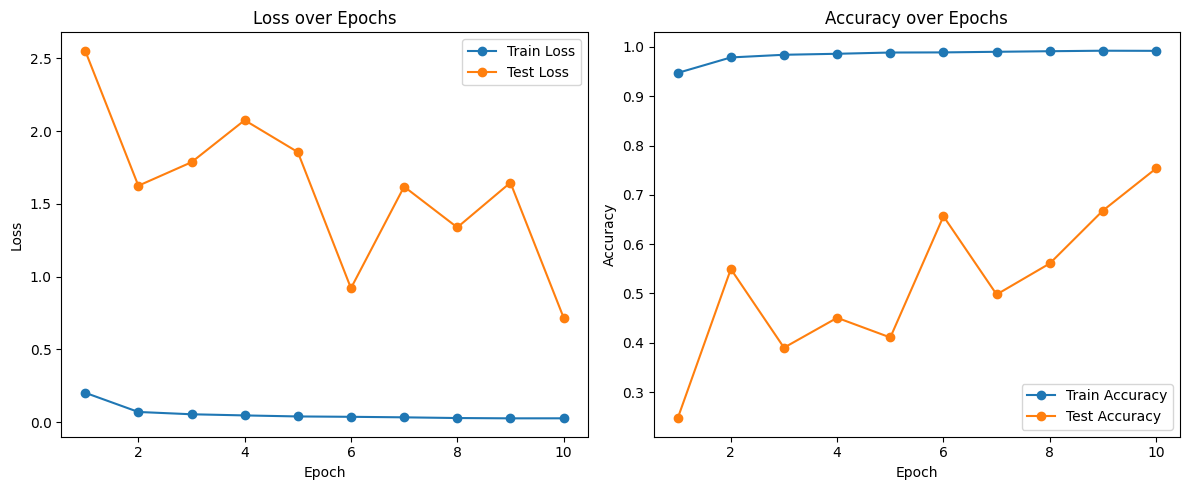

In [82]:
epochs = range(1, epochs + 1)

plt.figure(figsize = (12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label = 'Train Loss', marker = 'o')
plt.plot(epochs, test_losses, label = 'Test Loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label = 'Train Accuracy', marker = 'o')
plt.plot(epochs, test_accuracies, label = 'Test Accuracy', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
# review

# learning process
  # a bit surprising, overall learning was rather slow imo
  # learning itself seem a bit unstable

# result
  # far lower accuracy of test compared to that of training
  # may indicate overfitting

# next step
  # may well reorganize Residual block and ReNnetlike module
  # in the future possibly hyper-paratmeter tuning

#### Predict

define prediction fuction

In [86]:
def show_random_predictions(model, dataset, num_images = 5):
  '''
  args:
    model:
    dataset:
    num_images:
  return:

  '''
  # set model mode as evaluation
  model.eval()

  idxs = random.sample(range(len(dataset)), num_images)
  images = torch.stack([dataset[i][0] for i in idxs])
  labels = torch.stack([torch.tensor(dataset[i][1]) for i in idxs]) # Convert labels to tensors before stacking

  images = images.to(device)
  outputs = model(images)
  preds = outputs.argmax(dim = 1)

  plt.figure(figsize = (12, 3))
  for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap = 'gray')
    plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
    plt.axis('off')

  plt.tight_layout()
  plt.show()

execute and review

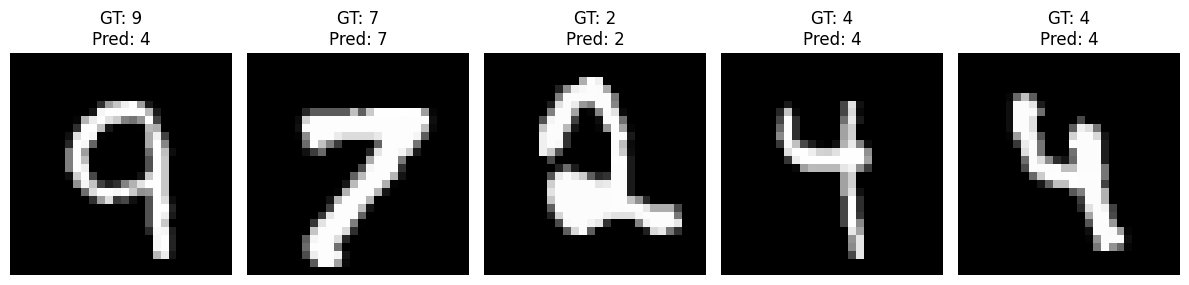

In [87]:
show_random_predictions(model, test_dataset, num_images = 5)

**Redefine** residual block

In [89]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 1):
    super(ResidualBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels,
                           kernel_size = 3, padding = 1, stride = stride, bias = False)
    self.conv2 = nn.Conv2d(out_channels, out_channels,
                           kernel_size = 3, padding = 1, stride = 1, bias = False)
    self.relu = nn.ReLU()
    self.norm = nn.BatchNorm2d(out_channels)


    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels,
                    kernel_size = 1, stride = stride, bias = False),
          nn.BatchNorm2d(out_channels))
    else:
      self.shortcut = nn.Identity()

  def forward(self, x):
    identity = self.shortcut(x)
    out = self.relu(self.norm(self.conv1(x)))
    out = self.norm(self.conv2(out))
    out += identity

    return self.relu(out)

**Redefine** residual network

In [95]:
class ResNetLike(nn.Module):
  def __init__(self):
    super(ResNetLike, self).__init__()
    self.stem = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 7, # following the paper
                  stride = 1, padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
    )

    self.layer1 = ResidualBlock(in_channels = 16, out_channels = 16)
    self.layer2 = ResidualBlock(16, 16)
    self.layer3 = ResidualBlock(16, 16)
    self.layer4 = ResidualBlock(16, 32)
    self.layer5 = ResidualBlock(32, 32)
    self.layer6 = ResidualBlock(32, 64)
    self.layer7 = ResidualBlock(64, 64)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.dropout = nn.Dropout(p = 0.2) # prevent overfitting
    self.fc = nn.Linear(in_features = 64, out_features = 10) # dense layer

  def forward(self, x):
    out = self.stem(x)
    out = self.layer3(self.layer2(self.layer1(out)))
    out = self.layer5(self.layer4(out))
    out = self.layer7(self.layer6(out))
    out = self.avgpool(out)
    out = self.dropout(torch.flatten(out, 1))
    return self.fc(out)

get model ready

In [96]:
model = ResNetLike().to(device)

define criterion(loss function) and optimizer

In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

set settings

In [98]:
batch_size = 32
epochs = 10
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

execute and review

In [99]:
epochs = 10

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
  train_loss, train_acc = train(model, train_loader)
  test_loss, test_acc = evaluate(model, test_loader)

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  test_losses.append(test_loss)
  test_accuracies.append(test_acc)

  print(f'[Epoch {epoch + 1}]'
        f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}  | '
        f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

[Epoch 1]Train Loss: 0.1607, Train Acc: 0.9556  | Test Loss: 3.2850, Test Acc: 0.3824
[Epoch 2]Train Loss: 0.0639, Train Acc: 0.9812  | Test Loss: 2.3181, Test Acc: 0.4243
[Epoch 3]Train Loss: 0.0525, Train Acc: 0.9847  | Test Loss: 2.5745, Test Acc: 0.4664
[Epoch 4]Train Loss: 0.0436, Train Acc: 0.9869  | Test Loss: 1.9683, Test Acc: 0.5159
[Epoch 5]Train Loss: 0.0373, Train Acc: 0.9889  | Test Loss: 2.5035, Test Acc: 0.3689
[Epoch 6]Train Loss: 0.0334, Train Acc: 0.9901  | Test Loss: 1.5744, Test Acc: 0.5074
[Epoch 7]Train Loss: 0.0278, Train Acc: 0.9918  | Test Loss: 3.3570, Test Acc: 0.1781
[Epoch 8]Train Loss: 0.0275, Train Acc: 0.9919  | Test Loss: 2.4258, Test Acc: 0.3966
[Epoch 9]Train Loss: 0.0248, Train Acc: 0.9922  | Test Loss: 2.0349, Test Acc: 0.3865
[Epoch 10]Train Loss: 0.0229, Train Acc: 0.9933  | Test Loss: 3.6844, Test Acc: 0.2983


In [88]:
# review
# wow it's even more deteriorating ;;